<a href="https://colab.research.google.com/github/ShevchenkOksana/Computer-Vision/blob/main/Computer_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install albumentations datasets > /dev/null

In [ ]:
pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=5e48b6a995a8f3668f7f22746adb31a915bb3597822ffd42d1a502f3e4893a19
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [ ]:
import os
import sys
import gzip
import struct
from typing import List

import albumentations as albu
import cv2
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from efficientnet_pytorch import EfficientNet

from datasets import load_dataset

import matplotlib.pyplot as plt
from IPython.display import Image


## Dataset - [Tiny ImageNet](https://huggingface.co/datasets/zh-plus/tiny-imagenet)


In [ ]:
dataset = load_dataset("frgfm/imagenette", "320px")
num_labels = 10

dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 9469
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 3925
    })
})

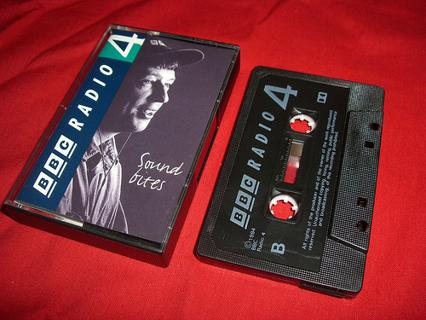

In [ ]:
dataset["train"][123]["image"]

In [ ]:
class HuggingFaceDataset(Dataset):
    def __init__(self, dataset: Dataset, augmentations: albu.Compose) -> None:
        self.dataset = dataset
        self.augs = augmentations

    def __len__(self) -> int:
        return len(self.dataset)

    def __getitem__(self, index) -> tuple:
        sample = self.dataset[index]
        image = sample["image"].convert("RGB")
        image = self.augs(image=np.array(image))["image"]
        image = torch.from_numpy(image).permute(2, 0, 1)
        label = torch.LongTensor([sample["label"]])
        return image, label

In [ ]:
def train_one_epoch(
    model: nn.Module,
    loader: DataLoader,
    criterion: nn.Module,
    optimizer: optim.Optimizer,
    device: str = "cpu",
    verbose: bool = True,
) -> dict:
    model = model.to(device)
    model.train()

    losses = []
    accuracies = []

    with tqdm(total=len(loader), desc="training", file=sys.stdout, ncols=100, disable=not verbose, smoothing=0.1) as progress:
        for x_batch, y_true in loader:
            x_batch = x_batch.to(device)
            y_true = y_true.squeeze(1).to(device)

            optimizer.zero_grad()
            y_pred = model(x_batch)
            loss = criterion(y_pred, y_true)
            loss.backward()
            optimizer.step()

            batch_accuracy = (y_pred.argmax(1) == y_true).float().mean().item()
            accuracies.append(batch_accuracy)

            losses.append(loss.item())
            progress.set_postfix_str(f"loss {losses[-1]:.4f}")
            progress.update(1)

    logs = {
        "losses": np.array(losses),
        "accuracies": np.array(accuracies)
    }
    return logs

In [ ]:
@torch.inference_mode()
def evaluate(
    model: nn.Module,
    loader: DataLoader,
    criterion: nn.Module,
    device: str = "cpu",
    verbose: bool = True,
) -> dict:
    model.eval()

    losses = []
    accuracies = []

    for x_batch, y_true in tqdm(loader, desc="evaluation", file=sys.stdout, ncols=100, disable=not verbose):
        x_batch = x_batch.to(device)
        y_true = y_true.squeeze(1).to(device)

        y_pred = model(x_batch)
        loss = criterion(y_pred, y_true)
        losses.append(loss.item())
        accuracies.append((y_pred.argmax(1) == y_true).float().detach().cpu().numpy())

    logs = {
        "losses": np.array(losses),
        "accuracies": np.concatenate(accuracies)
    }
    return logs

In [ ]:
def test_model (model_test, batch_size, n_epochs):
  input_shape = (224, 224)  # NOTE: to spedup training you can decrease an input shape, it will decrease the final score
  workers = os.cpu_count()

# TODO: optional, play with augmentations
  train_augs = albu.Compose([
    albu.OneOf([
        albu.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=20, border_mode=cv2.BORDER_REPLICATE),
        albu.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=20, border_mode=cv2.BORDER_REFLECT),
        albu.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=20, border_mode=cv2.BORDER_WRAP),
        albu.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=20, border_mode=cv2.BORDER_REFLECT_101),
    ]),
    albu.HorizontalFlip(),
    albu.Resize(*input_shape),
    albu.Normalize(),  # will be used ImageNet mean and std
  ])

  train_loader = DataLoader(
    HuggingFaceDataset(dataset["train"], train_augs),
    batch_size=batch_size,
    num_workers=workers,
    shuffle=True,
    drop_last=True,
  )

  valid_augs = albu.Compose([
    albu.Resize(*input_shape),
    albu.Normalize(),  # will be used ImageNet mean and std
  ])

  valid_loader = DataLoader(
    HuggingFaceDataset(dataset["validation"], valid_augs),
    batch_size=batch_size,
    num_workers=workers,
    shuffle=False,
    drop_last=False,
  )

  train_losses = []
  train_accuracies = []

  valid_losses = []
  valid_accuracies = []

  for ep in range(n_epochs):
    print(f"\nEpoch {ep + 1:2d}/{n_epochs:2d}")

    train_logs = train_one_epoch(model_test, train_loader, loss_fn, optimizer, device, verbose=True)
    train_losses.append(np.mean(train_logs["losses"]))
    train_accuracies.append(np.mean(train_logs["accuracies"]))
    print("      loss:", train_losses[-1])
    print("  accuracy:", train_accuracies[-1])


    valid_logs = evaluate(model_test, valid_loader, loss_fn, device, verbose=True)
    valid_losses.append(np.mean(valid_logs["losses"]))
    valid_accuracies.append(np.mean(valid_logs["accuracies"]))
    print("      loss:", valid_losses[-1])
    print("  accuracy:", valid_accuracies[-1])


  fix, axes = plt.subplots(ncols=2, figsize=(15, 4))

  axes[0].plot(np.arange(len(train_losses)), train_losses, ".-")
  axes[0].plot(np.arange(len(valid_losses)), valid_losses, ".-")
  axes[0].legend(["train", "validation"])
  axes[0].set_title(f"Loss - Batch Size: {batch_size}, Epochs: {n_epochs}, Model: {model_test.__class__.__name__}")
  axes[0].grid()

  axes[1].plot(np.arange(len(train_accuracies)), train_accuracies, ".-")
  axes[1].plot(np.arange(len(valid_accuracies)), valid_accuracies, ".-")
  axes[1].legend(["train", "validation"])
  axes[1].set_title(f"Accuracy - Batch Size: {batch_size}, Epochs: {n_epochs}, Model: {model_test.__class__.__name__}")
  axes[1].grid();

Device - cuda

Loaded pretrained weights for efficientnet-b3
Number of trainable parameters - 10711602

Epoch  1/10
training: 100%|██████████████████████████████████████| 147/147 [02:06<00:00,  1.16it/s, loss 0.2536]
      loss: 0.3048441187560964
  accuracy: 0.9200680272108843
evaluation: 100%|███████████████████████████████████████████████████| 62/62 [00:16<00:00,  3.79it/s]
      loss: 0.22096241080778106
  accuracy: 0.94318473

Epoch  2/10
training: 100%|██████████████████████████████████████| 147/147 [02:06<00:00,  1.17it/s, loss 0.1163]
      loss: 0.15657883266709288
  accuracy: 0.953125
evaluation: 100%|███████████████████████████████████████████████████| 62/62 [00:16<00:00,  3.82it/s]
      loss: 0.2807357840750727
  accuracy: 0.9238216

Epoch  3/10
training: 100%|██████████████████████████████████████| 147/147 [02:06<00:00,  1.17it/s, loss 0.1149]
      loss: 0.11187156649673877
  accuracy: 0.9667304421768708
evaluation: 100%|██████████████████████████████████████████████████

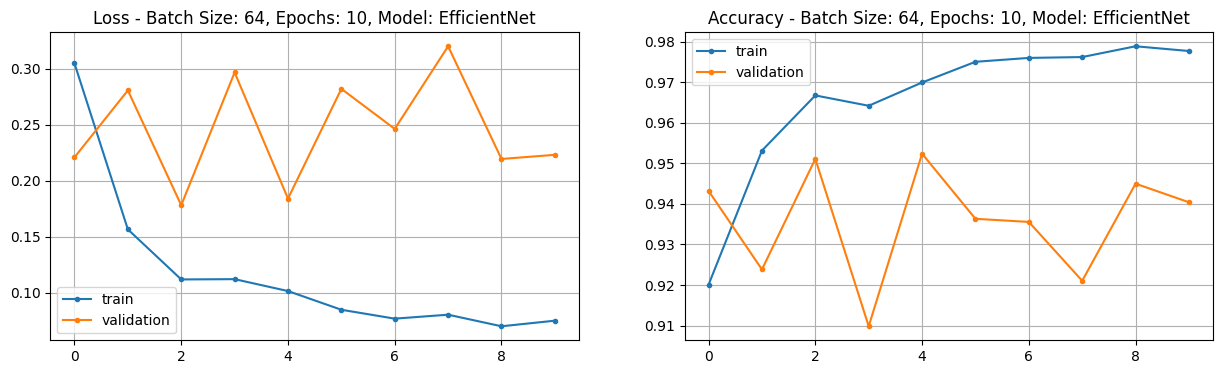

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device - {device}\n")
# 1 EfficientNet variant b0, b1, b2, ..., b7
efficientnet_variant = 'b3'
Efficient_Net = EfficientNet.from_pretrained(f'efficientnet-{efficientnet_variant}', num_classes=num_labels)
Efficient_Net = Efficient_Net.to(device)
print("Number of trainable parameters -", sum(p.numel() for p in Efficient_Net.parameters() if p.requires_grad))
optimizer = optim.Adam(Efficient_Net.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()
test_model(Efficient_Net, 64, 10)

Device - cuda

Number of trainable parameters - 2236682

Epoch  1/10
training: 100%|██████████████████████████████████████| 147/147 [00:48<00:00,  3.00it/s, loss 0.2619]
      loss: 0.4354936102417862
  accuracy: 0.8645833333333334
evaluation: 100%|███████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.29it/s]
      loss: 0.30900182010185334
  accuracy: 0.90267515

Epoch  2/10
training: 100%|██████████████████████████████████████| 147/147 [00:50<00:00,  2.94it/s, loss 0.2389]
      loss: 0.27539381699091725
  accuracy: 0.9150722789115646
evaluation: 100%|███████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.80it/s]
      loss: 0.3060907907783985
  accuracy: 0.9067516

Epoch  3/10
training: 100%|██████████████████████████████████████| 147/147 [00:48<00:00,  3.02it/s, loss 0.1274]
      loss: 0.24801097437739372
  accuracy: 0.9193239795918368
evaluation: 100%|███████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.64it/s]
   

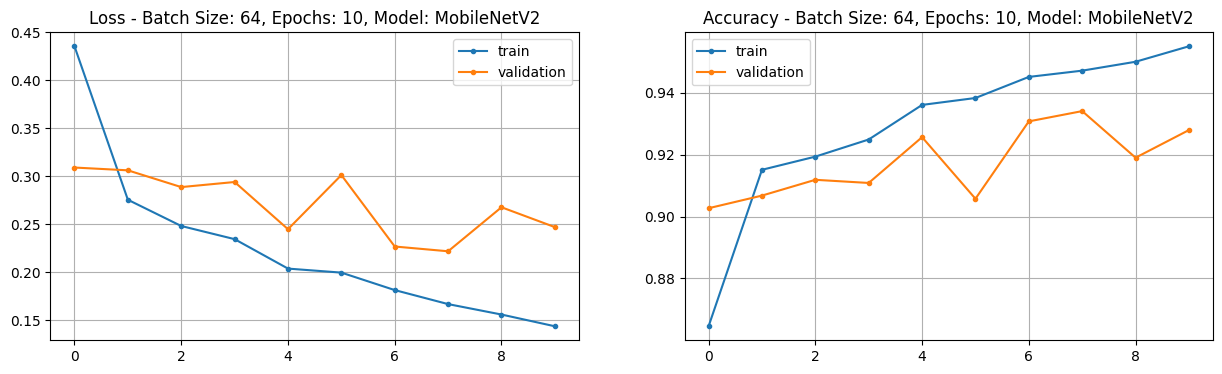

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device - {device}\n")
# 2 MobileNetV2
Mobile_Net = models.mobilenet_v2(pretrained=True)
Mobile_Net.classifier[1] = nn.Linear(Mobile_Net.classifier[1].in_features, num_labels)
Mobile_Net = Mobile_Net.to(device)
print("Number of trainable parameters -", sum(p.numel() for p in Mobile_Net.parameters() if p.requires_grad))
optimizer = optim.Adam(Mobile_Net.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()
test_model(Mobile_Net, 64, 10)

Device - cuda



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:08<00:00, 62.0MB/s]


Number of trainable parameters - 134301514

Epoch  1/10
training: 100%|██████████████████████████████████████| 147/147 [02:08<00:00,  1.14it/s, loss 1.8087]
      loss: 2.165848301381481
  accuracy: 0.21301020408163265
evaluation: 100%|███████████████████████████████████████████████████| 62/62 [00:19<00:00,  3.12it/s]
      loss: 1.7851709262017281
  accuracy: 0.37044585

Epoch  2/10
training: 100%|██████████████████████████████████████| 147/147 [02:07<00:00,  1.15it/s, loss 1.6445]
      loss: 1.8221820382033886
  accuracy: 0.3561862244897959
evaluation: 100%|███████████████████████████████████████████████████| 62/62 [00:19<00:00,  3.14it/s]
      loss: 1.5810417888625976
  accuracy: 0.46012738

Epoch  3/10
training: 100%|██████████████████████████████████████| 147/147 [02:08<00:00,  1.15it/s, loss 1.5005]
      loss: 1.6594600661271284
  accuracy: 0.4161352040816326
evaluation: 100%|███████████████████████████████████████████████████| 62/62 [00:19<00:00,  3.14it/s]
      loss: 1.5078

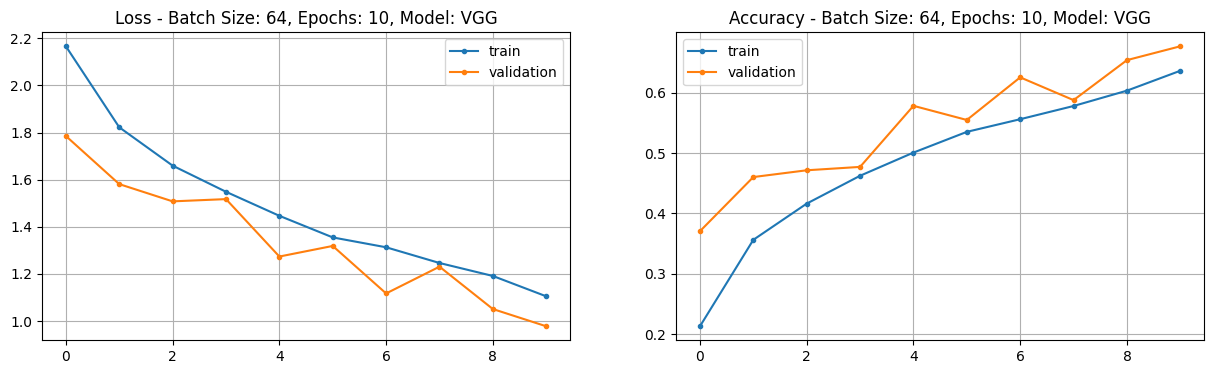

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device - {device}\n")
# 3 VGG16
VGG = models.vgg16(pretrained=True)
VGG.classifier[6] = nn.Linear(VGG.classifier[6].in_features, num_labels)
VGG = VGG.to(device)
print("Number of trainable parameters -", sum(p.numel() for p in VGG.parameters() if p.requires_grad))
optimizer = optim.Adam(VGG.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()
test_model(VGG, 64, 10)

Device - cuda



Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 149MB/s]


Number of trainable parameters - 11181642

Epoch  1/10
training: 100%|██████████████████████████████████████| 147/147 [00:45<00:00,  3.21it/s, loss 0.2904]
      loss: 0.5365310319426919
  accuracy: 0.8347151360544217
evaluation: 100%|███████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.30it/s]
      loss: 0.48479257536030584
  accuracy: 0.8450955

Epoch  2/10
training: 100%|██████████████████████████████████████| 147/147 [00:45<00:00,  3.26it/s, loss 0.2412]
      loss: 0.3823206836269015
  accuracy: 0.8790391156462585
evaluation: 100%|███████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.30it/s]
      loss: 0.48529899400103116
  accuracy: 0.8568153

Epoch  3/10
training: 100%|██████████████████████████████████████| 147/147 [00:44<00:00,  3.32it/s, loss 0.6874]
      loss: 0.313425413554623
  accuracy: 0.9023171768707483
evaluation: 100%|███████████████████████████████████████████████████| 62/62 [00:09<00:00,  6.31it/s]
      loss: 0.613564

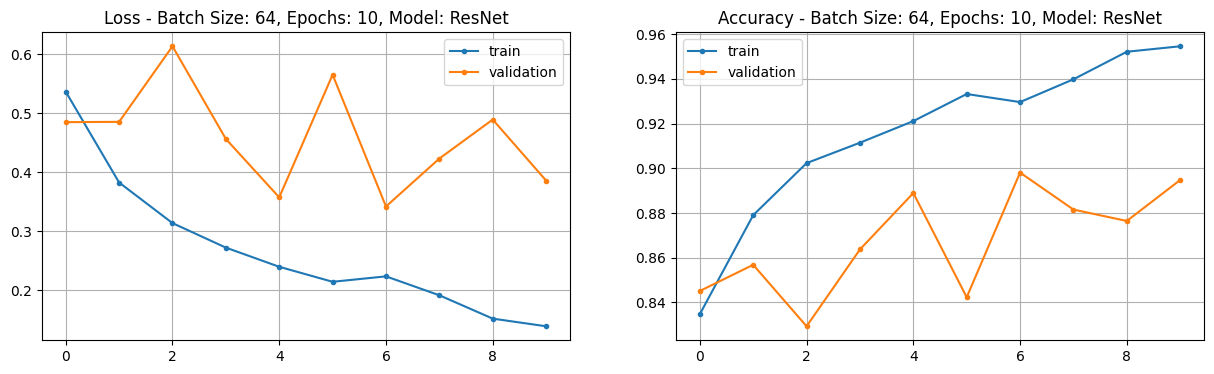

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device - {device}\n")
# 4 Res_Net
Res_Net = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
torch.manual_seed(42)
Res_Net.fc = nn.Linear(Res_Net.fc.in_features, num_labels)
Res_Net = Res_Net.to(device)
print("Number of trainable parameters -", sum(p.numel() for p in Res_Net.parameters() if p.requires_grad))
optimizer = optim.Adam(Res_Net.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()
test_model(Res_Net, 64, 10)

[All result](https://drive.google.com/file/d/1XoG2Ox-RDi1ew-QtexS29ThV126ztMuB/view?usp=drive_link)

Using a batch size of 64 and running for 10 epochs, I evaluated the performance of the following architectures:

- EfficientNet
- MobileNet
- VGG
- ResNet

The results are as follows:

**EfficientNet:**
- Training data: Loss approximately 0.08, Accuracy approximately 0.98.
- Validation data: Loss approximately 0.22, Accuracy approximately 0.94.

**MobileNet:**
- Training data: Loss approximately 0.14, Accuracy approximately 0.95.
- Validation data: Loss approximately 0.25, Accuracy approximately 0.93.

**VGG:**
- Training data: Loss approximately 1.11, Accuracy approximately 0.64.
- Validation data: Loss approximately 0.98, Accuracy approximately 0.68.

**ResNet:**
- Training data: Loss approximately 0.14, Accuracy approximately 0.95.
- Validation data: Loss approximately 0.39, Accuracy approximately 0.89.


Efficient Net gives the best result. In the next step I tried to get a better result from Efficient Net. I increased the number of epochs to 25, but I had an out of memory error. So I had to reduce the image size to 160px.


Device - cuda

Loaded pretrained weights for efficientnet-b3
Number of trainable parameters - 10711602

Epoch  1/25
training: 100%|██████████████████████████████████████| 147/147 [02:05<00:00,  1.17it/s, loss 0.4510]
      loss: 0.3187939487651092
  accuracy: 0.9145408163265306
evaluation: 100%|███████████████████████████████████████████████████| 62/62 [00:16<00:00,  3.84it/s]
      loss: 0.5581644114769709
  accuracy: 0.91057324

Epoch  2/25
training: 100%|██████████████████████████████████████| 147/147 [02:05<00:00,  1.17it/s, loss 0.1037]
      loss: 0.17296351553226003
  accuracy: 0.9496173469387755
evaluation: 100%|███████████████████████████████████████████████████| 62/62 [00:16<00:00,  3.80it/s]
      loss: 0.36235399105616156
  accuracy: 0.90726113

Epoch  3/25
training: 100%|██████████████████████████████████████| 147/147 [02:05<00:00,  1.17it/s, loss 0.1108]
      loss: 0.12226020816561518
  accuracy: 0.9642857142857143
evaluation: 100%|███████████████████████████████████████

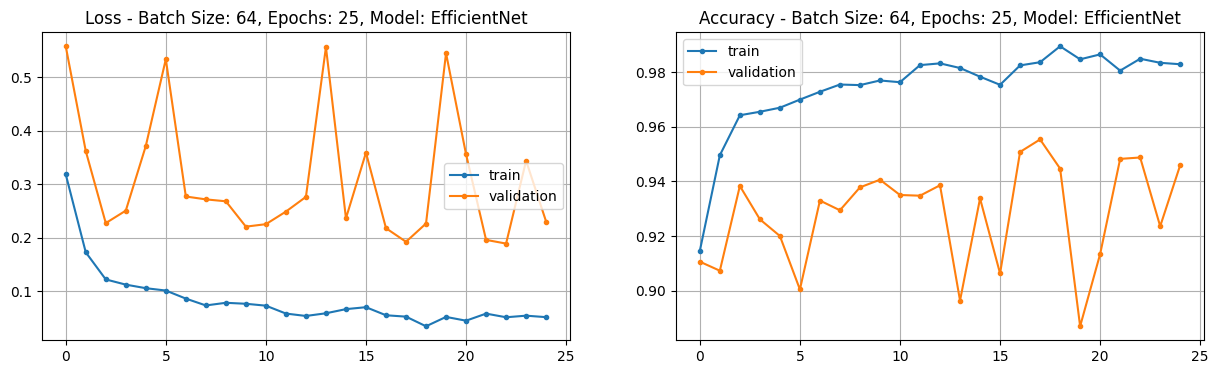

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device - {device}\n")
dataset = load_dataset("frgfm/imagenette", "160px")
num_labels = 10
dataset
# EfficientNet variant b0, b1, b2, ..., b7
efficientnet_variant = 'b3'
Efficient_Net = EfficientNet.from_pretrained(f'efficientnet-{efficientnet_variant}', num_classes=num_labels)
Efficient_Net = Efficient_Net.to(device)
print("Number of trainable parameters -", sum(p.numel() for p in Efficient_Net.parameters() if p.requires_grad))
optimizer = optim.Adam(Efficient_Net.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()
test_model(Efficient_Net, 64, 25)

*Result after 10 Epochs*:

training:

    loss: 0.07503158079941763, accuracy: 0.9776785714285714

evaluation:

    loss: 0.2231814373517409, accuracy: 0.9403822



*Result after 25 Epochs:*

training:

    loss: 0.05173184917439853, accuracy: 0.9829931972789115

evaluation:

    loss: 0.23043626293562533, accuracy: 0.9459873

Let's try increse epochs to 50

Device - cuda

Loaded pretrained weights for efficientnet-b2
Number of trainable parameters - 7715084

Epoch  1/50
training: 100%|██████████████████████████████████████| 147/147 [01:35<00:00,  1.54it/s, loss 0.1450]
      loss: 0.30699168145656586
  accuracy: 0.9204931972789115
evaluation: 100%|███████████████████████████████████████████████████| 62/62 [00:12<00:00,  4.95it/s]
      loss: 0.22544937990906258
  accuracy: 0.93859875

Epoch  2/50
training: 100%|██████████████████████████████████████| 147/147 [01:35<00:00,  1.53it/s, loss 0.2103]
      loss: 0.15600636799116524
  accuracy: 0.9555697278911565
evaluation: 100%|███████████████████████████████████████████████████| 62/62 [00:12<00:00,  4.80it/s]
      loss: 0.21306734544862505
  accuracy: 0.9414013

Epoch  3/50
training: 100%|██████████████████████████████████████| 147/147 [01:35<00:00,  1.54it/s, loss 0.0916]
      loss: 0.1079208003610474
  accuracy: 0.9659863945578231
evaluation: 100%|████████████████████████████████████████

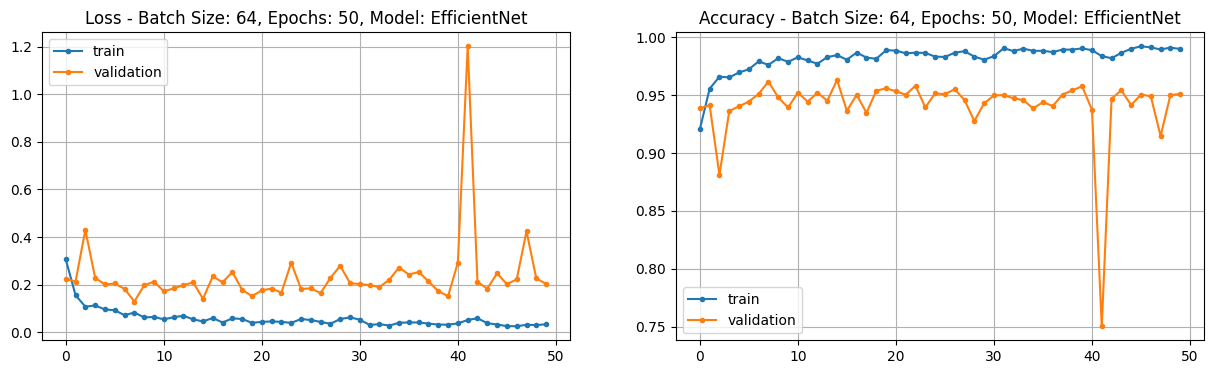

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device - {device}\n")
dataset = load_dataset("frgfm/imagenette", "160px")
num_labels = 10
dataset
# EfficientNet variant b0, b1, b2, ..., b7
efficientnet_variant = 'b2'
Efficient_Net = EfficientNet.from_pretrained(f'efficientnet-{efficientnet_variant}', num_classes=num_labels)
Efficient_Net = Efficient_Net.to(device)
print("Number of trainable parameters -", sum(p.numel() for p in Efficient_Net.parameters() if p.requires_grad))
optimizer = optim.Adam(Efficient_Net.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()
test_model(Efficient_Net, 64, 50)

Result after 50 Epochs:

training:

      loss: 0.03415455636497093, accuracy: 0.9899022108843537

evaluation:

      loss: 0.20376516794673197, accuracy: 0.9510828

Using more epochs gives a better result